In [1]:
import pandas as pd
import os
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import datetime
import netCDF4 as nc

In [2]:
XRS_FOLDER = os.path.join('..','EUVs','xrs_netcdf')
EUVS_FOLDER = os.path.join('..','EUVs')
YEARS = [2013,2014]

CUR_DIR = os.path.abspath(os.getcwd())

xrs_files = glob.glob(os.path.join(CUR_DIR,XRS_FOLDER,'*.nc'))
xrs_files.sort()

euvs_files = glob.glob(os.path.join(CUR_DIR,EUVS_FOLDER,'*.nc'))
euvs_files

['l:\\PhD\\TEC\\utilities\\..\\EUVs\\dn_geuv-l2-cpy1m_g15_y2014_v4-0-0.nc',
 'l:\\PhD\\TEC\\utilities\\..\\EUVs\\dn_geuv-l2-cpy1m_g15_y2013_v4-0-0.nc']

D:\Programs\Anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  if __name__ == '__main__':
D:\Programs\Anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:9: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  if __name__ == '__main__':


<AxesSubplot:xlabel='time'>

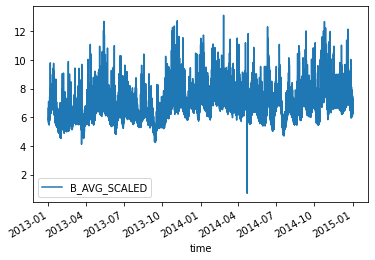

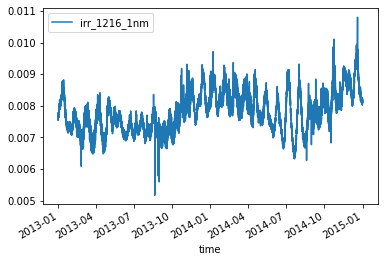

In [3]:
xrs_df = pd.DataFrame(columns=['time','B_AVG'])
euvs_df = pd.DataFrame(columns=['time','irr_1216_1nm'])

for xrs_file in xrs_files:
    ncDs = nc.Dataset(xrs_file)
    # print(ncDs.variables.keys())
    time = np.array(list(map(datetime.datetime.utcfromtimestamp,np.array(ncDs['time_tag'])/1000)))
    time = pd.Series(time,name='time')
    b_avg = np.array(ncDs['B_AVG'])
    b_avg = pd.Series(b_avg,name='B_AVG')

    xrs_df = xrs_df.append(pd.concat([b_avg, time], axis=1),ignore_index=True)

xrs_df[xrs_df['B_AVG'] <= 0] = np.nan
xrs_df['time'] = xrs_df['time'].dt.round(freq='min')
xrs_df.dropna(inplace=True)
xrs_df.sort_values(by='time',ascending=True,inplace=True)

xrs_df['B_AVG_SCALED'] = np.log(xrs_df['B_AVG'] * 1e+9 + 1)

# xrs_df.plot(x='time',y='B_AVG')
xrs_df.plot(x='time',y='B_AVG_SCALED')


for euv_file in euvs_files:
    ncDs = nc.Dataset(euv_file)
    # print(ncDs.variables.keys())
    time = np.array(list(map(datetime.datetime.utcfromtimestamp,np.array(ncDs['time']))))
    time = pd.Series(time,name='time')
    b_avg = np.array(ncDs['irr_1216_1nm'])
    b_avg = pd.Series(b_avg,name='irr_1216_1nm')

    euvs_df = euvs_df.append(pd.concat([b_avg, time], axis=1),ignore_index=True)

euvs_df[euvs_df['irr_1216_1nm'] <= 0] = np.nan

# euvs_df['time'] = pd.to_datetime(euvs_df['time'],format='%Y-%m-%d %H:%M:%S')
euvs_df['time'] = euvs_df['time'].dt.round(freq='min')
euvs_df.dropna(inplace=True)
euvs_df.sort_values(by='time',ascending=True,inplace=True)
euvs_df.plot(x='time',y='irr_1216_1nm')

In [15]:
df = pd.merge_asof(xrs_df,euvs_df,on='time')
df

,time,B_AVG,B_AVG_SCALED,irr_1216_1nm
0,2013-01-01 00:00:00,3.670910e-07,5.908330,0.007599
1,2013-01-01 00:01:00,3.593080e-07,5.886959,0.007610
2,2013-01-01 00:02:00,3.599440e-07,5.888723,0.007615
3,2013-01-01 00:03:00,3.657340e-07,5.904637,0.007610
4,2013-01-01 00:04:00,3.757740e-07,5.931646,0.007604
...,...,...,...,...
1035153,2014-12-31 23:55:00,1.014670e-06,6.923304,0.008150
1035154,2014-12-31 23:56:00,1.012770e-06,6.921431,0.008148
1035155,2014-12-31 23:57:00,1.005850e-06,6.914582,0.008148
1035156,2014-12-31 23:58:00,1.002010e-06,6.910761,0.008142


<AxesSubplot:xlabel='irr_1216_1nm'>

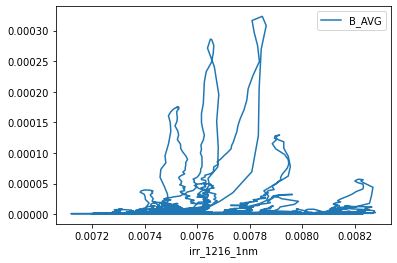

In [17]:
_start = datetime.datetime(2013,5,1)
_end   = datetime.datetime(2013,5,30)
mask = (df['time'] >= _start) & (df['time'] < _end) 

df[mask].plot(y='B_AVG',x='irr_1216_1nm')
# df.plot.scatter(y='irr_1216_1nm',x='B_AVG_SCALED')